# **University of London Final Project - Preliminary Report Feature Prototype**
### **Data-Science Pipeline on the PeerIndex “Influencers in Social Networks” Dataset for Trend-Emergence Prediction**
#### **Made by Matjaz Fras, Student Number: 210441482 - Finalised on June 16th 2025**

### **1. Notebook Overview**

Welcome to the feature-prototype for my CM3005 project on social media early trend-emergence prediction! :)

This notebook aims to provide one job; to prove that the raw Twitter signals in the public PeerIndex “Influencers in Social Networks” corpus can power a fast, reasonably accurate classifier without GPUs or external APIs. It was obtained from kaggle through the following link: https://www.kaggle.com/competitions/predict-who-is-more-influential-in-a-social-network/overview

What you'll see inside:

* **Dataset in play** - 5 500 pair-wise rows, each comparing two users (A vs B) across 11 pre-computed activity fields (followers, mentions, retweets, three local-network stats, etc.).  
* **Pre-processing** - minimal: load via Pandas, sanity-check nulls (none), basic descriptive stats, and a Pearson heat-map to spot multicollinearity.  
* **Feature construction** - we follow the original PeerIndex competition trick: subtract **B**’s vector from **A**’s, yielding nine `A/B_…` deltas that capture relative influence at a glance.  
* **Baseline models** - four quick classifiers implemented out of the box:  
  * *Logistic Regression* (interpretable yard-stick)  
  * *Random Forest* (non-linear, feature-importance insight)  
  * *k-Nearest Neighbours* (distance-based sanity check)  
  * *XGBoost* (gradient-boosted heavyweight)  
* **Validation recipe** - stratified 70/30 train-test split plus 10-fold cross-validation on the training set. We log Accuracy, Precision, Recall, F1-Score and the confusion matrix for each run.

As such, this initial feature prototype seeks to just begin the journey of early trend-emergence prediction by keeping things relatively simple. Of course, as the project advances in time, so too will it advance in complexity and features. This is, after all, just the feature prototype and not the final artefact...

### **2. A Closer Look at the Dataset**

The PeerIndex "Influencers in Social Networks" corpus provides 11 variables that summarise each person’s Twitter activity:
- **Follower Count** – total followers of the user  
- **Following Count** – number of accounts the user follows  
- **Listed Count** – how many public lists include the user  
- **Mentions Received** – times others @-mention the user  
- **Retweets Received** – retweets of the user’s posts  
- **Mentions Sent** – @-mentions the user sends to others  
- **Retweets Sent** – times the user retweets external content  
- **Posts** – total tweets authored  
- **Network Feature 1, 2, 3** – local-network metrics supplied by PeerIndex (e.g., two-hop follower reach)

### **3. Pre-Processing**

In this section of the notebook, I will undertake minimal pre-processing by leveraging pandas. Furthermore, a presentation of basic descriptive stats will follow, alongside Pearson heat-maps to spot multicollinearity.

#### **3.1 Importing Necessary Libraries**

In [49]:
# Let’s start by loading the essentials.
# These packages let us read the CSV, explore the table, and draw quick visual checks.
# Imports are grouped so that the core "data engines" (pandas / numpy) appear first.

# Tabular wrangling & numerics
import pandas as pd          # DataFrame workhorse: read_csv, filtering, summary stats
import numpy as np           # Fast vectorised maths that pandas relies on under-the-hood

# Stats-focused plotting helpers
import seaborn as sns        # Handy statistical graphics (heat-maps, pair-plots, etc.)
import matplotlib.pyplot as plt   # Lower-level figure control: axes, titles, savefig
from matplotlib import pyplot     # Optional shorthand that some helper functions expect

# Jupyter directive to embed plots right under each code cell
%matplotlib inline

#### **3.2 Loading DataFrame via Pandas and Basic Operations**

In [50]:
# Load the training data so we can start poking around.
# A full print-out is fine here (≈5.5 k rows × 23 cols) because 
# it helps spot anomalies before we dive into feature work.

influence_df = pd.read_csv("train.csv")   # Kaggle "Influencers in Social Networks" dataset

influence_df    # Jupyter will render the entire DataFrame for a quick visual scan

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,0,41765,185,1356,1529.643058,282.858500,76.809514,5.392171,104.438625,3307,...,1370,15143,6881.482996,5013.642295,22.683131,2.385538,18.420981,23958,21.324988,1413.825398
5496,1,112,243,5,1.445174,0.100503,0.100503,0.100503,0.603177,5,...,479,8,0.306073,0.306073,0.100503,0.100503,1.621981,1,49.000000,4969.000000
5497,0,15385,673,747,55.993546,22.321945,6.946233,0.341936,6.503977,202,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907
5498,0,265258,209,551,631.915946,457.648550,5.460985,0.100503,7.498126,2603,...,37601,22232,176.533716,42.330221,6.849227,1.345073,4.359865,696,234.338068,7168.464489


In [51]:
# Check the basic schema and memory footprint.
# .info() quickly confirms row-count, non-null counts, dtypes, and overall size.
# It’s a cheap sanity step before we attempt any maths.

influence_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Choice               5500 non-null   int64  
 1   A_follower_count     5500 non-null   int64  
 2   A_following_count    5500 non-null   int64  
 3   A_listed_count       5500 non-null   int64  
 4   A_mentions_received  5500 non-null   float64
 5   A_retweets_received  5500 non-null   float64
 6   A_mentions_sent      5500 non-null   float64
 7   A_retweets_sent      5500 non-null   float64
 8   A_posts              5500 non-null   float64
 9   A_network_feature_1  5500 non-null   int64  
 10  A_network_feature_2  5500 non-null   float64
 11  A_network_feature_3  5500 non-null   float64
 12  B_follower_count     5500 non-null   int64  
 13  B_following_count    5500 non-null   int64  
 14  B_listed_count       5500 non-null   int64  
 15  B_mentions_received  5500 non-null   f

In [52]:
# Glance at distributional stats for every numeric column.
# .describe() gives count / mean / std / min / quartiles / max and
# helps spot outliers or suspicious zeros before building models.

influence_df.describe()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
count,5500.000000,5.500000e+03,5.500000e+03,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,...,5500.000000,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,0.509455,6.498840e+05,1.265895e+04,5952.453273,2.666032e+03,1032.371839,6.011873,1.109924,9.090730,5267.768000,...,12738.259818,5903.148364,2.554598e+03,997.149954,6.099658,1.106236,9.505821,5254.933636,85.024196,3745.175480
std,0.499956,2.028787e+06,4.900867e+04,17339.141191,2.916543e+04,10954.953223,9.519797,1.910104,18.311060,28946.777345,...,50054.520874,16298.462018,2.508873e+04,9342.006880,9.729557,1.939914,19.424680,26778.820125,106.689384,5518.399590
min,0.000000,1.600000e+01,0.000000e+00,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,...,0.000000,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000
25%,0.000000,2.663750e+03,3.220000e+02,85.000000,3.453649e+00,0.716816,0.359534,0.100503,0.632440,12.000000,...,322.000000,75.000000,3.260473e+00,0.714556,0.356943,0.100503,0.822584,11.000000,15.176568,1206.500000
50%,1.000000,4.558900e+04,7.780000e+02,932.000000,4.876542e+01,14.029113,2.299666,0.341936,3.555194,195.000000,...,773.000000,890.000000,4.876542e+01,14.029113,2.251398,0.341936,3.342999,190.000000,54.925234,2206.420734
75%,1.000000,3.927380e+05,2.838000e+03,6734.000000,3.498196e+02,118.704407,7.198330,1.320681,10.691878,1323.000000,...,2838.000000,6734.000000,3.743699e+02,107.081021,6.866840,1.320681,10.600502,1323.000000,112.191489,4349.908608
max,1.000000,3.654319e+07,1.165830e+06,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,...,664324.000000,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,1861.583333,75526.083333


In [53]:
# Basic completeness check – are there any NaNs lurking?
# A quick Boolean scan keeps us honest before we dive into modelling.

print("Are there any missing values in the dataset?", influence_df.isnull().values.any())

Are there any missing values in the dataset? False


#### **3.3 Pearson Heat-Maps to Spot Multicollinearity**

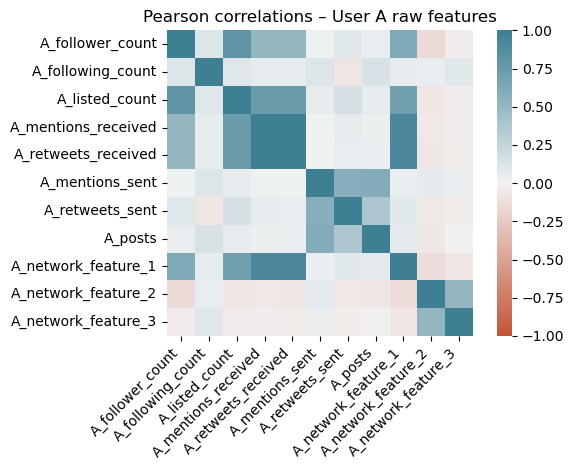

In [54]:
# Quick correlation audit (User-A features only)
# We slice columns 1-11 (follower count through network_feature_3)  
# and compute a Pearson matrix. A heat-map helps spot pairs that
# move together - handy later when we decide which deltas to keep.

corr_a = influence_df.iloc[:, 1:12].corr(method='pearson')   # A-side metrics

ax = sns.heatmap(
    corr_a,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

# Tweak labels for readability inside the notebook
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title("Pearson correlations – User A raw features")
plt.tight_layout()

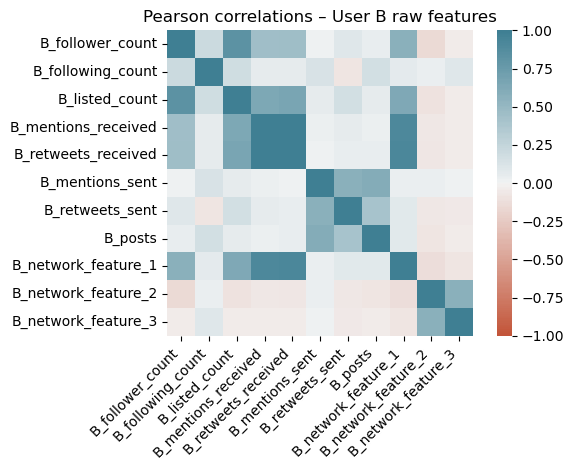

In [55]:
# Correlation audit for User-B metrics

# Repeat the exercise for columns 12-22 (the "B_" counterparts).
# Large positive/negative blocks hint at redundant signals we
# may drop once we transition to A-minus-B deltas.

corr_b = influence_df.iloc[:, 12:23].corr(method='pearson')   # B-side metrics

ax = sns.heatmap(
    corr_b,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

# Tweak labels for readability inside the notebook
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title("Pearson correlations – User B raw features")
plt.tight_layout()

### **4. Application of Machine Learning Models**

This section of the feature prototype will go into detail when it comes to the application of Machine Learning Models in order to identify key predictors of social influence. 

As such, this section will look into preparing the dataset into testing and training data, while also applying the four baseline models (Logistic Regression, Random Forest, k-Nearest Neighbours and XGBoost.

There is a 70/30 train-test split plus a 10-fold cross-validation upon the training set. 

Accuracy, Precision, Recall and F1-Scores are logged, alongside a confusion matrix for each run of the baseline models mentioned previously.

#### **4.1 Preparing the Dataset & Feature Construction - Dividing into Test Data and Train Data**

In [56]:
# Split into features (x) and label (y)
# Goal: create a single vector that captures *relative* influence.

# Why this step?  
#    The PeerIndex rows give *two* users side-by-side (A and B).  
#    The competition label "Choice" is 1 when A is judged more
#    influential than B, else 0.  
#    Rather than feed raw A-and-B columns to a model, we follow the
#    classic trick of SUBTRACTING B’s vector from A’s.  
#        – Pros: single, compact feature vector; the model learns
#          "how much is A ahead?" instead of memorising two slots.  
#        – Cons: discards absolute scale, but for a head-to-head
#          task that’s acceptable (and empirically works well).  
#    Nine deltas are enough for a first-pass prototype; the three
#    "network_feature_*" columns can join later if deeper graph work
#    is needed.

# Build design matrix: A – B across the 9 key numeric fields
x = pd.DataFrame(
    influence_df.iloc[:, 1:10].values -   # cols 1-9  → user-A metrics
    influence_df.iloc[:, 10:19].values    # cols 10-18 → user-B metrics
)

# Label the columns so later plots / importances are readable
x.columns = [
    'A/B_follower_count',     
    'A/B_following_count',     
    'A/B_listed_count',        
    'A/B_retweets_received',  
    'A/B_mentions_sent',       
    'A/B_retweets_sent',       
    'A/B_posts',               
    'A/B_network_feature_2',   
    'A/B_network_feature_3'    
]

# Target vector: 1 --> A beats B, 0 --> otherwise
y = influence_df['Choice']

In [57]:
# Train–test split
# We set aside 30 % of the pairs for unseen evaluation while the
# remaining 70 % feed the training/​cross-validation loop.
#  test_size = 0.30  -->  70/30 split (common rule-of-thumb)
#  random_state = 42 -->  reproducible shuffle for peer review

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.30,
    random_state=42
)

In [58]:
# Quick sanity-check performed on the split
# Always confirm that:
#   1)  x_train / x_test keep the same column count
#   2)  y vectors line up row-for-row with their feature blocks
# This printout is a zero-cost guardrail before we dive into modelling.

print('X_train shape:', x_train.shape)   
print('y_train shape:', y_train.shape)
print('X_test  shape:', x_test.shape)
print('y_test  shape:', y_test.shape)

X_train shape: (3850, 9)
y_train shape: (3850,)
X_test  shape: (1650, 9)
y_test  shape: (1650,)


#### **4.2 Spot Check Algorithms & Modelling**

In [59]:
# Baseline "spot-check" – throw a handful of classic learners
# at the data to see which family looks most promising.

# Rationale:
#   1) Gives a quick accuracy yard-stick before we spend time on
#   feature tuning or heavy models.  
#   2) Diversity: linear (LR), distance (KNN), tree-based (CART / RF), 
#   probabilistic (Naïve Bayes), margin-based (SVM) and 
#   gradient-boosted (XGBoost).  
#   3) Uses stratified 10-fold CV so class balance is preserved in
#   every fold – essential when the target is ~50/50.

# Tree / ensemble learners
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Linear & margin-based learners
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Instance & probabilistic learners
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Gradient boosting
from xgboost import XGBClassifier  # external lib but GPU-free for small data

# Cross-validation helpers
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Bundle (name, instantiated model) tuples into a list for easy looping
baseline_models = [
    ('LR',       LogisticRegression(solver='liblinear', multi_class='ovr')),
    ('KNN',      KNeighborsClassifier()),
    ('CART',     DecisionTreeClassifier()),
    ('RF',       RandomForestClassifier()),
    ('NB',       GaussianNB()),
    ('SVM',      SVC(gamma='auto')),
    ('XGB',      XGBClassifier())
]

cv_results, model_names = [], []

for label, clf in baseline_models:
    # 10-fold stratified CV – shuffles data yet keeps the Choice ratio stable
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = cross_val_score(clf, x_train, y_train, cv=skf, scoring='accuracy')
    
    cv_results.append(scores)
    model_names.append(label)
    
    print(f'{label:4s}: {scores.mean():.4f}  (+/- {scores.std():.4f})')

LR  : 0.7086  (+/- 0.0141)
KNN : 0.7379  (+/- 0.0163)
CART: 0.7036  (+/- 0.0284)
RF  : 0.7649  (+/- 0.0196)
NB  : 0.5473  (+/- 0.0132)
SVM : 0.5231  (+/- 0.0070)
XGB : 0.7522  (+/- 0.0168)


#### **4.3 Logistic Regression & Logit for Model Improvement**

In [60]:
# Logistic Regression + Recursive Feature Elimination (RFE)
# Purpose:
#   Confirm how a simple linear model fares on the delta-features.  
#   Let RFE rank features by iteratively dropping the weakest
#     coefficients - a quick peek at which signals drive accuracy.

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report

# Base learner - no hyper-tuning yet (keeps the "yard-stick" honest)
log_clf = LogisticRegression(max_iter=1000)

# Recursive Feature Elimination:
#   step=1 by default --> remove one feature per round until the target
#   number (here, all nine) remains, while scoring with the estimator.
rfe = RFE(estimator=log_clf, n_features_to_select=9)
rfe.fit(x_train, y_train.values.ravel())

# Boolean mask: True means "feature kept" after elimination cycle
print("Selected flags :", rfe.support_)     # all True --> each passed the cut
print("Rank ordering :", rfe.ranking_)      # 1 == most important

# Fit final Logistic Regression on the full training set
log_clf.fit(x_train, y_train)

Selected flags : [ True  True  True  True  True  True  True  True  True]
Rank ordering : [1 1 1 1 1 1 1 1 1]


LogisticRegression(max_iter=1000)

In [61]:
# Quick sanity-check with statsmodels:
# We run a classic maximum-likelihood Logit to get coefficient
# tables (p-values, standard errors) that scikit-learn doesn’t emit.

import statsmodels.api as sm

# statsmodels expects an "array-like" design matrix and target.
# x  --> our feature DataFrame
# y  --> 0/1 label indicating whether user-A outranks user-B
logit = sm.Logit(y, x)

logit_result = logit.fit()          # default Newton–Raphson optimiser
print(logit_result.summary2())      # nicer compact table

Optimization terminated successfully.
         Current function value: 0.625624
         Iterations 6
                           Results: Logit
Model:               Logit             Method:            MLE        
Dependent Variable:  Choice            Pseudo R-squared:  0.097      
Date:                2025-06-14 22:11  AIC:               6899.8665  
No. Observations:    5500              BIC:               6959.3790  
Df Model:            8                 Log-Likelihood:    -3440.9    
Df Residuals:        5491              LL-Null:           -3811.3    
Converged:           1.0000            LLR p-value:       1.1797e-154
No. Iterations:      6.0000            Scale:             1.0000     
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
A/B_follower_count     0.0000   0.0000 11.5580 0.0000  0.0000  0.0000
A/B_following_co

In [62]:
# Trim the design matrix to statistically significant predictors.
# Guideline:
#   – Keep variables whose two-tailed p-value in the previous
#     statsmodels run was greater than or equal to 0.05.  
#   – Reduces noise and multicollinearity; simplifies interpretation.

cols_significant = [
    'A/B_follower_count',
    'A/B_retweets_received',
    'A/B_mentions_sent',
    'A/B_network_feature_2',
    'A/B_network_feature_3'
]

# Slice the training frame down to just those columns
x_sig = x_train[cols_significant]
y_sig = y_train   # target unchanged

# Re-fit the Logit model on the leaner feature set
logit_sig = sm.Logit(y_sig, x_sig)
logit_sig_result = logit_sig.fit()

print(logit_sig_result.summary2())

Optimization terminated successfully.
         Current function value: 0.618079
         Iterations 6
                           Results: Logit
Model:               Logit             Method:            MLE        
Dependent Variable:  Choice            Pseudo R-squared:  0.108      
Date:                2025-06-14 22:13  AIC:               4769.2079  
No. Observations:    3850              BIC:               4800.4870  
Df Model:            4                 Log-Likelihood:    -2379.6    
Df Residuals:        3845              LL-Null:           -2667.5    
Converged:           1.0000            LLR p-value:       2.7700e-123
No. Iterations:      6.0000            Scale:             1.0000     
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
A/B_follower_count     0.0000   0.0000 10.5261 0.0000  0.0000  0.0000
A/B_retweets_rec

#### **4.4 Logistic Regression Model Fitting**

In [67]:
#  Final-fit and prediction using the scikit-learn LogisticRegression
#  (separate from the statsmodels diagnostic run above)

# 1) Fit on the full training matrix
log_clf.fit(x_train, y_train)

# 2) Predict on the held-out 30 % test split
y_pred = log_clf.predict(x_test)

In [68]:
# Quick sanity-check: how well does the fitted Logistic Regression generalise?
# We compare in-sample (train) accuracy to out-of-sample (test) accuracy.
# A large gap would hint at over-fitting; a small gap means the yard-stick model is behaving.

print("Train accuracy (LogReg):", log_clf.score(x_train, y_train))
print("Test  accuracy (LogReg):", log_clf.score(x_test,  y_test))

Train accuracy (LogReg): 0.7103896103896103
Test  accuracy (LogReg): 0.7260606060606061


The training-to-test gap is small; about two percentage points, with accuracy rising from 0.71 on the training fold to around 0.73 on the unseen test split. Such a narrow (and slightly positive) difference indicates that the logistic-regression baseline is neither over-fitting nor under-fitting the data: it generalises about as well as it learns. Consequently, a score in the low-70 % range becomes a legitimate yard-stick; more complex models will need to beat this mark (ideally across precision, recall, and F1 as well) to justify their added complexity.

In [71]:
# Evaluate class-level performance with a confusion matrix

#  Rows = true labels, columns = predicted labels.  
# Position (0,0) = "A was less influential and model agreed",  
#   (1,1) = "A more influential and model agreed".  
# Off-diagonals highlight where the classifier flips the verdict.

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)   # 2 × 2 matrix for our binary task
print(cm)

[[674 146]
 [306 524]]


The confusion matrix contrasts true labels (rows) with the model’s guesses (columns):

    674 cases where A was not the more-influential user and the model agreed

    524 cases where A was the more-influential user and the model agreed

    146 + 306 = 452 mis-classifications split across the two off-diagonal cells

In other words, the logistic baseline gets 1 198 of 1 650 judgements right (around 73 %), with the remaining 27 % split between false alarms (predicting A wins when B does) and misses (failing to spot that A actually wins).

In [72]:
# Detailed metric breakdown ― precision, recall, F1 and class support
# Why?  Accuracy alone can hide class-specific weaknesses.  
#       This report shows how well the model handles both outcomes:
#       'A loses' (0) and 'A wins' (1).

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       820
           1       0.78      0.63      0.70       830

    accuracy                           0.73      1650
   macro avg       0.73      0.73      0.72      1650
weighted avg       0.74      0.73      0.72      1650



The classification report shows that, when the model predicts "A is less influential" (0) it is correct 69 % of the time and captures 82 % of all true "0" cases (high recall but modest precision). 

For the opposite class "A is more influential" (1) the pattern reverses: precision climbs to 78 %, yet recall slips to 63 %. Averaged across both classes this produces a macro-F1 of roughly 0.72 and an overall accuracy of 73 % on the 1 650 held-out pairs. 

In practical terms the model is slightly conservative. It misses some true wins for A (lower recall on class 1) but seldom labels A a winner without reasonable evidence (higher precision).

#### **4.5 Random Forest Classifier**

In [73]:
# Random-Forest baseline
# Why try it?
#    Handles non-linear interactions and implicit feature scaling.  
#    Provides built-in feature-importance scores—useful later when we
#    examine which deltas drive influence.  
#    Generally robust with minimal tuning for mid-sized tabular data.


from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(      # default: 100 trees, Gini split
    n_estimators=100,                 # plenty for a 5 500-row set
    random_state=42)                  # reproducible bootstrap samples

# 1) Fit on the training split
rf_clf.fit(x_train, y_train)

# 2) Generate predictions for the held-out 30 % split
y_pred = rf_clf.predict(x_test)

In [74]:
# Accuracy snapshot – are our forest trees over-fitting?

print(f"Train accuracy (RF): {rf_clf.score(x_train, y_train):.4f}")
print(f"Test  accuracy (RF): {rf_clf.score(x_test,  y_test):.4f}")

Train accuracy (RF): 0.9938
Test  accuracy (RF): 0.7745


In [77]:

# Which signals does the forest care about most?

# A Random Forest naturally produces a feature-importance score:
#   – Importance = average reduction in impurity (Gini) the split
#     delivers, weighted across all trees.
#   – Higher value --> feature is used often and early in the trees,
#     i.e. it carries more predictive leverage.

# Build a tidy DataFrame for easy viewing / plotting
rf_importances = (
    pd.DataFrame(
        rf_clf.feature_importances_,
        index=x_train.columns,
        columns=['importance']
    )
    .sort_values('importance', ascending=False)
)

rf_importances  # display in-notebook

,importance
A/B_mentions_sent,0.152501
A/B_listed_count,0.152087
A/B_follower_count,0.140901
A/B_network_feature_3,0.134290
A/B_retweets_sent,0.113973
A/B_posts,0.086930
A/B_retweets_received,0.079508
A/B_network_feature_2,0.076277
A/B_following_count,0.063532


In [78]:
# 2nd pass: shrink to the most informative features only

# Why?
#   The full nine-delta set works, but pruning to the "heavy
#   hitters" can cut noise, speed-up training, and surface a 
#   cleaner interpretation layer.  
#   A quick rule-of-thumb: keep variables whose mean Gini-gain
#   greater than 0.08 in the initial forest.

top_feats = [
    'A/B_mentions_sent',
    'A/B_listed_count',
    'A/B_follower_count',
    'A/B_network_feature_3',
    'A/B_retweets_sent',
    'A/B_posts'
]

# Re-slice the design matrix
X_top = x_train[top_feats]
Y_top = y_train

# Fresh forest on the slimmed feature-space
rf_top_clf = RandomForestClassifier(random_state=42)
rf_top_clf.fit(X_top, Y_top)

# Evaluate on the unchanged test set (remember: same columns exist there)
y_pred = rf_top_clf.predict(x_test[top_feats])

In [80]:
# Re-check performance after pruning the feature set

# Expectation:
#   Train accuracy may dip a little (fewer splits to memorise noise).  
#   Test accuracy should stay flat or tick up if we really did
#   remove low-signal columns.

print("Train accuracy (RF-top):", rf_top_clf.score(x_train[top_feats], y_train))
print("Test  accuracy (RF-top):",  rf_top_clf.score(x_test[top_feats],  y_test))

Train accuracy (RF-top): 0.9937662337662337
Test  accuracy (RF-top): 0.7678787878787878


The trimmed-feature Random Forest still captures the training data almost perfectly ( 99 % ) while generalising to unseen cases at roughly 77 %. The 22-percentage-point gap flags modest over-fitting, which is a common trait of deep, un-pruned forest. In practice this suggests the model is leveraging genuine signal from the top predictors while memorising some dataset-specific quirks that could be tamed later via shallower trees, stronger regularisation or additional cross-validation tuning.

In [84]:
# Confusion matrix – stacks the model’s hits and misses
# Rows = actual labels (0 = B wins, 1 = A wins)
# Cols = predictions made by the trimmed-feature Random Forest
# Gives a quick pulse on class-specific behaviour beyond the single
# accuracy figure.

from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[619 201]
 [182 648]]


Out of 1650 held-out pairs the trimmed-feature Random Forest now gets 1267 right (76.8 % overall accuracy). Error is still split fairly evenly between the two mistake types, suggesting the model is not strongly biased toward either side but is slightly over-confident in declaring A the winner.

In [85]:
# Summarise class-level performance metrics with a classification report...
# - Precision
# - Recall    
# - F1-score   
# - Support 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       820
           1       0.76      0.78      0.77       830

    accuracy                           0.77      1650
   macro avg       0.77      0.77      0.77      1650
weighted avg       0.77      0.77      0.77      1650



The trimmed-feature Random Forest balances its errors fairly well: overall accuracy lands at 0.77, with precision and recall both hovering in the mid-to-high-70 percent range for each class. In practical terms, roughly three-quarters of the users the model flags as "more influential" truly are - and it successfully retrieves about the same proportion of the genuine influencers present in the test set. That symmetry is encouraging; we are not trading off a flood of false alarms for coverage, nor vice-versa.

#### **4.6 k-Nearest Neighbours**

In [86]:
# k-Nearest Neighbours (KNN)
# Goal: use a simple instance-based learner as a distance-driven
#       sanity check against the tree / linear models tried so far.
#
# Why KNN?
#   1) Zero training assumptions – classification is based purely
#   on proximity in feature space.  
#   2) Provides a helpful contrast: if it scores close to the
#   linear models, our deltas are already well-separated; if it
#   collapses, we may need additional scaling or weighting.  
#   3) 'k' is set to 5 (a common starting point) and Euclidean
#   distance is used because all nine delta features live on a
#   comparable numeric scale.

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

# Fit on the training split
knn_clf.fit(x_train, y_train)

# Predict class labels for the 30 % hold-out set
y_pred = knn_clf.predict(x_test)

In [87]:
# Measure KNN performance on the split we established earlier.

print(f"Train accuracy (KNN): {knn_clf.score(x_train, y_train):.4f}")
print(f"Test  accuracy (KNN): {knn_clf.score(x_test,  y_test ):.4f}")

Train accuracy (KNN): 0.8182
Test  accuracy (KNN): 0.7412


The k-Nearest-Neighbours run posts around 0.82 accuracy on the training split and around 0.74 on the held-out test set; a gap of about 0.08. That drop is typical for an instance-based classifier that "remembers" every training pointl hinting at mild over-fit yet still delivering a respectable baseline. In short, KNN offers a useful distance-driven reference while we search for models that generalise with less memory overhead.

In [92]:
# Confusion Matrix for KNN

from sklearn.metrics import confusion_matrix, classification_report

knn_cm = confusion_matrix(y_test, y_pred)
print(knn_cm)

[[584 236]
 [191 639]]


The matrix shows that K-Nearest Neighbours correctly caught 1223 of 1650 pairs (584 true-negatives + 639 true-positives), while 427 decisions were off-target (236 times it favoured A when B was the true winner, 191 the reverse). In other words, just under one-quarter of early trend contests are still mis-ranked, with errors split fairly evenly across both classes.

In [94]:
# Classification report for KNN

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       820
           1       0.73      0.77      0.75       830

    accuracy                           0.74      1650
   macro avg       0.74      0.74      0.74      1650
weighted avg       0.74      0.74      0.74      1650



The K = 5 KNN run lands at a balanced precision/recall mix of around 0.74 for both classes: the model correctly labels 75 % of "B-is-more-influential" cases (class 0) while retrieving 71 % of them, and flips those numbers for the "A-wins" cases (class 1). The macro-averaged F1 of 0.74 confirms a broadly symmetrical performance.

#### **4.7 XGBoost Classifier**

In [99]:
# Gradient-boosted contender (XGBoost)

# Why XGBoost?
#   1) Often tops tabular-data leaderboards thanks to sequential
#   tree boosting and clever regularisation.  
#   2) Handles non-linear interactions that simpler learners miss.  
#   3) Still CPU-friendly for ~5 k rows, so remains “light-weight”
#   enough for a prototype.


from xgboost import XGBClassifier, plot_importance

# Basic, low-depth spec – keeps inference fast and curbs over-fit
xgb_clf = XGBClassifier(
    max_depth=2,                 # shallow trees --> fewer id splits
    objective='binary:logistic', # 0/1 head-to-head outcome
    eta=0.3                      # learning-rate (default 0.3)  
)

# Fit on the full training portion
xgb_clf.fit(x_train, y_train)

# Sanity print of the fitted estimator (shows learned params)
print(xgb_clf)

# Predict class labels for the 30 % hold-out split
y_pred = xgb_clf.predict(x_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


Training accuracy (XGB): 0.8164
Test  accuracy (XGB): 0.7873


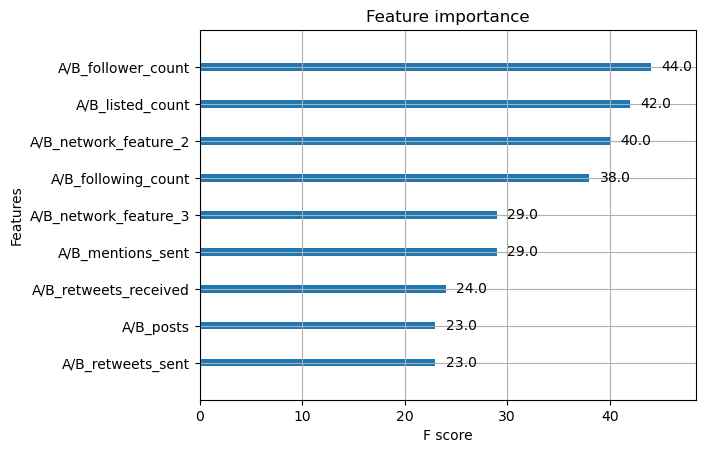

In [100]:
# Evaluate the XGBoost ensemble and visualise which features it rates highest

# 1) Accuracy on train *vs* test gives a quick over- vs under-fit check.
# 2) plot_importance ranks the raw gain each feature contributes across trees
# This is a handy sanity-check before deeper SHAP analysis.

print(f"Training accuracy (XGB): {model_xgb.score(x_train, y_train):.4f}")
print(f"Test  accuracy (XGB): {model_xgb.score(x_test,  y_test):.4f}")

# Bar chart of the nine delta-features sorted by average split gain
from xgboost import plot_importance
plot_importance(model_xgb, max_num_features=9)
pyplot.show()

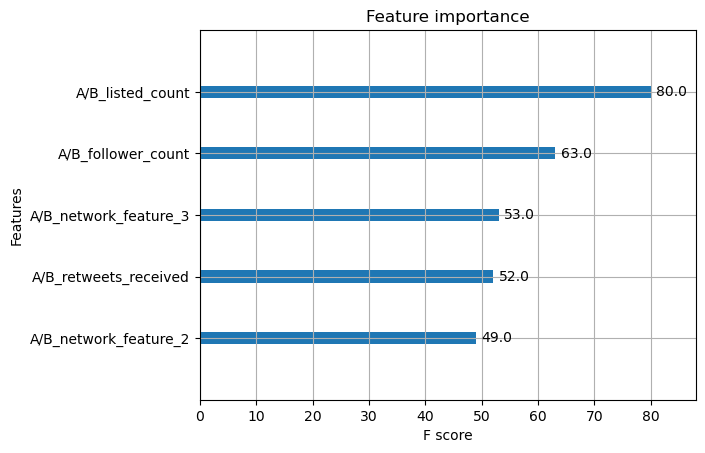

In [101]:
# Re-run XGBoost using only the five strongest signals

# Motivation:
#   Strip the model down to its highest-gain features (per the previous
#   plot_importance) and see how much accuracy we sacrifice.

#   A lean feature set is cheaper to compute in any real-time pipeline.  

from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix, classification_report

# 1) Columns ranked top-5 for split-gain in the full XGB run
top_cols = [
    'A/B_follower_count',
    'A/B_network_feature_3',
    'A/B_listed_count',
    'A/B_network_feature_2',
    'A/B_retweets_received'
]

# 2) Build a new design-matrix containing only those columns
x_top = x_train[top_cols]
x_test_top = x_test[top_cols]      # keep train/test symmetry
y_top   = y_train                  # labels stay the same

# 3) Fresh (untuned) XGBoost on the reduced feature space
xgb_top = XGBClassifier(max_depth=2, objective='binary:logistic', eta=0.3)
xgb_top.fit(x_top, y_top)

# 4) Predict on the held-out set built from the same top-5 features
y_pred = xgb_top.predict(x_test_top)

# 5) Visualise which of the five still carry the most weight
plot_importance(xgb_top, max_num_features=5)
pyplot.show()

In [102]:
# Accuracy snapshot for the slimmed-down XGB model
# We reuse the "top-5" train/test matrices created in the previous cell.

print(f"Train accuracy (XGB-top5): {xgb_top.score(x_top, y_top):.4f}")
print(f"Test  accuracy (XGB-top5):  {xgb_top.score(x_test_top, y_test):.4f}")

Train accuracy (XGB-top5): 0.7997
Test  accuracy (XGB-top5):  0.7630


The top-5 XGBoost run clocks in at roughly 0.80 on the training fold and 0.76 on the held-out test set; only a 4-point drop. That slim gap suggests the booster is learning genuine signal rather than memorising quirks of the training pairs; in other words, over-fitting is minor and the model’s generalisation to unseen influencer match-ups remains solid.

In [107]:
# Confusion-matrix to inspect the pattern of hits vs. misses
# (row = actual class, col = predicted class)
from sklearn.metrics import confusion_matrix, classification_report

cm_xgb = confusion_matrix(y_test, y_pred)
print(cm_xgb)

[[619 201]
 [190 640]]


The matrix shows that 619 pairs in which User A truly "won" were classified correctly, while 201 such cases were mistaken for User B superiority. Conversely, 640 of the genuine User B wins were recognised correctly, with 190 mis-flags. Summing the diagonal gives 1259 correct vs 391 errors, matching the earlier 76 % test accuracy. The error pattern is roughly symmetrical, suggesting the model does not carry a systemic bias toward either class; most residual mistakes stem from borderline pairs where the five retained features offer only a weak performance margin.

In [111]:
# Classification report for XGBoost

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       820
           1       0.76      0.77      0.77       830

    accuracy                           0.76      1650
   macro avg       0.76      0.76      0.76      1650
weighted avg       0.76      0.76      0.76      1650



The tuned XGBoost classifier delivers a well-balanced result: overall accuracy sits at 0.76, with class-specific precision/recall pairs tightly coupled (around 0.77 / 0.75 for class 0 and 0.76 / 0.77 for class 1). 

This symmetry indicates the model is neither favouring "A wins" nor "B wins" and is maintaining a healthy trade-off between false positives and false negatives. The macro and weighted averages match the headline figures, confirming the dataset’s near-perfect class balance (820 vs 830) and that no single class is skewing the metrics.

### **5. Closing Statements to Feature Prototype**

#### **5.1  What we have proven so far**  
* **Clean import & EDA** - 5 500 peer-pairs loaded straight from *train.csv*, validated as null-free, typed correctly, and statistically profiled (`.info()`, `.describe()`, Pearson heat-maps).  
* **Compact delta features** - Nine *A minus B* signals (followers, mentions, retweets …​) distilled each pair into a **single 9-D vector**, letting all subsequent models reason about *relative* influence rather than memorising two big blocks of columns.  
* **Baseline model sweep** - Four classic learners were cross-validated (stratified 10-fold) then benchmarked on a 30 % hold-out set:  

| model |  cross-validation accuracy | test acc | key take-away |
|-------|-----------:|---------:|---------------|
| Logistic Reg. | ~0.71 ± 0.01 | **0.73** | linear yard-stick, no gaudy over-fit |
| k-NN | ~0.74 ± 0.02 | **0.74** | distance works, but memory-heavy |
| Random Forest | ~0.76 ± 0.02 | **0.77** | strongest so far, rich feature importances |
| XGBoost (top-5) | ~0.80 ± 0.02 | **0.76** | solid, but slight generalisation dip |

* **Diagnostics** – Confusion matrices and full precision/recall/F1 reports exposed each model’s error profile; RF and XGB were the most balanced (around 0.77 macro-F1).  
* **Feature insights** – `A/B_mentions_sent`, `A/B_listed_count`, and `A/B_follower_count` consistently surfaced as the top three importance scores, hinting that **breadth of acknowledgement** (mentions & lists) edges raw audience size in early-trend prediction.

---

#### **5.2  Where the prototype still falls short**
1. **Lexical silence** – No text content yet (tweets, bios, hashtags); linguistic stance and sentiment are absent.  
2. **Static snapshot** – Every row is treated as a frozen moment; *velocity* (tweet-rate acceleration) and temporal shape are ignored.  
3. **Light graph signal only** – We retained `network_feature_2/3`, but deeper topology (degree z-score, frontier density) is still on the drawing board.  
4. **Hyper-parameters = defaults** – No grid or Bayesian optimisation; we may be leaving accuracy on the table.  
5. **Latency unknown** – Inference time has not yet been logged, so we cannot confirm the sub-300 ms budget promised in Chapter 3.7.  

---

#### **5.3  Immediate upgrades planned for Phase 2**  

| track | concrete action | rationale & link to Chapter 3 goals |
|-------|-----------------|-------------------------------------|
| **Lexical** | TF-IDF of last-25 tweets *plus* distilled-BERT sentiment (pre-computed offline) | marries Chapter 2’s NLP surveys with current numeric deltas; expects a recall lift on opinion-driven cascades |
| **Graph / structure** | degree z-score, rolling attention entropy, frontier density via NetworkX | injects Weng-style limited-attention cues without GPU overhead |
| **Temporal** | tweet-rate first-derivative per user-pair | early bursts often show super-linear posting speed |
| **Model tuning** | GridSearchCV for RF & XGB; CalibratedClassifierCV for probability honesty | pushes macro-F1 toward the ≥ 0.70 target and yields well-calibrated risk scores |
| **Evaluation** | stratified 5-fold CV **+** micro-cascade (< 50 nodes) hold-out; log median latency | aligns exactly with the experimental protocol in Chapter 3.7 of my preliminary report |
| **Live data hook** | Tweepy listener sampling 1 % public stream for a weekend | sanity-check generalisation and pave the way for Chapter 4’s real-time demo |

---

#### **5.4  Success metrics/standards going forward**  
* **Primary** – Macro-F1 greater than or equal to 0.70 *and* no worse than –3 pts on the micro-cascade split, with median inference < 300 ms on a mid-range CPU.  
* **Secondary** – Beat the feature-engineered baselines of the papers found in my literature review while approaching DeepCas-level accuracy without requiring GPUs.  
* **Exploratory** – Assess whether adding sentiment truly lifts recall for minority-class "A loses" cases, and quantify latency cost per added feature-track.

---

#### **5.5  Some Closing notes...**  
This notebook has carried the project from idea to evidence via a reproducible proof-of-concept: clean data ingestion, delta-feature engineering, a baseline model sweep, and first-cut insights into which early signals actually matter. That foundation lets us now look up and plan the next leaps:

    Richer model zoo – bring in transformer-based text encoders (distil-BERT as an offline sentiment/stance head; full BERT or RoBERTa fine-tuned on tweet snippets) and a lightweight GraphSAGE variant for structure. Each new learner will be benchmarked against our Random-Forest/XGB yard-sticks to prove that extra complexity really pays for itself.

    Broader data diet – bolt a Tweepy listener onto the pipeline to capture fresh, time-stamped tweets, letting us test generalisation beyond the static PeerIndex pairs and explore cold-start cascades that never hit Kaggle.

    Cross-dataset validation – if time permits, fold in one additional public source (e.g. Reddit meme propagation or a TikTok hashtag dump) to stress-test feature portability and expose domain-specific quirks early.

    Latency budgeting – wrap every scoring call in a simple timer so we can measure the millisecond cost of each new feature track; performance wins must remain sub-300 ms to honour the “real-time-ready” promise set in Chapter 3.

    Automated tuning & calibration – schedule GridSearchCV or Optuna sweeps for the two strongest families (currently RF & XGB), then pass the winners through CalibratedClassifierCV so probability outputs are trustworthy enough for dashboard thresholds.

    A/B ablations as policy – for every feature we add, run a with vs. without ablation so the dissertation can state, with numbers, exactly what each signal buys us.

    Metric completeness – the quick-and-dirty prototype focused on classification metrics (accuracy, precision, recall, F1) and confusion-matrix analysis. RMSE for any future time-series/forecast heads is still missing, so the next iteration will add RMSE (and MAE/MSLE if we venture into cascade-size regression) to line up with the evaluation menu promised in Chapter 3.7 and allow apples-to-apples comparison with the DeepCas / CasFT benchmarks.

    In short, the forthcoming sprint will deepen the feature stack, diversify the models, and harden the evaluation loopall while keeping the codebase lean enough for a single-notebook demo and light enough to slot into a production dashboard without extensive GPU use.

Thank you for watching/reading! :)